# Modeling & Forecasting

This notebook evaluates baseline and SARIMA models for forecasting daily 911 call volume using time-based validation.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load raw 911 call data
df = pd.read_csv("../data/philadelphia_911.csv")

df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,10-12-2015 17:10,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,10-12-2015 17:29,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,10-12-2015 14:39,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,10-12-2015 16:47,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,10-12-2015 16:56,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


In [4]:
# Parse timestamps (handles mixed formats)
df["timeStamp"] = pd.to_datetime(
    df["timeStamp"],
    format="mixed",
    dayfirst=True
)

df["timeStamp"].dtype

dtype('<M8[ns]')

In [5]:
# Set timestamp as index for time-series operations
df = df.set_index("timeStamp")

df.index

DatetimeIndex(['2015-12-10 17:10:00', '2015-12-10 17:29:00',
               '2015-12-10 14:39:00', '2015-12-10 16:47:00',
               '2015-12-10 16:56:00', '2015-12-10 15:39:00',
               '2015-12-10 16:46:00', '2015-12-10 16:17:00',
               '2015-12-10 16:51:00', '2015-12-10 17:35:00',
               ...
               '2020-07-29 15:33:00', '2020-07-29 15:34:00',
               '2020-07-29 15:35:00', '2020-07-29 15:32:00',
               '2020-07-29 15:38:00', '2020-07-29 15:46:00',
               '2020-07-29 15:52:00', '2020-07-29 15:52:00',
               '2020-07-29 15:54:00', '2020-07-29 15:52:00'],
              dtype='datetime64[ns]', name='timeStamp', length=663522, freq=None)

In [6]:
# Aggregate to daily 911 call counts
daily_calls = df.resample("D").size()

daily_calls.head()

timeStamp
2015-12-10    114
2015-12-11    391
2015-12-12    402
2015-12-13    316
2015-12-14    444
Freq: D, dtype: int64

In [7]:
# Ensure no missing days in the time series
daily_calls = daily_calls.asfreq("D", fill_value=0)

daily_calls.isna().sum()

np.int64(0)

In [8]:
# Convert Series to DataFrame
ts_df = daily_calls.to_frame(name="call_volume")

ts_df.head()

,call_volume
timeStamp,
2015-12-10,114
2015-12-11,391
2015-12-12,402
2015-12-13,316
2015-12-14,444


In [9]:
# Lag features
ts_df["lag_1"] = ts_df["call_volume"].shift(1)
ts_df["lag_7"] = ts_df["call_volume"].shift(7)
ts_df["lag_14"] = ts_df["call_volume"].shift(14)

ts_df.head(15)

,call_volume,lag_1,lag_7,lag_14
timeStamp,,,,
2015-12-10,114,NaN,NaN,NaN
2015-12-11,391,114.0,NaN,NaN
2015-12-12,402,391.0,NaN,NaN
2015-12-13,316,402.0,NaN,NaN
2015-12-14,444,316.0,NaN,NaN
2015-12-15,419,444.0,NaN,NaN
2015-12-16,376,419.0,NaN,NaN
2015-12-17,387,376.0,114.0,NaN
2015-12-18,346,387.0,391.0,NaN


In [10]:
# Rolling average features
ts_df["roll_7"] = ts_df["call_volume"].rolling(window=7).mean()
ts_df["roll_14"] = ts_df["call_volume"].rolling(window=14).mean()

ts_df.head(15)

,call_volume,lag_1,lag_7,lag_14,roll_7,roll_14
timeStamp,,,,,,
2015-12-10,114,NaN,NaN,NaN,NaN,NaN
2015-12-11,391,114.0,NaN,NaN,NaN,NaN
2015-12-12,402,391.0,NaN,NaN,NaN,NaN
2015-12-13,316,402.0,NaN,NaN,NaN,NaN
2015-12-14,444,316.0,NaN,NaN,NaN,NaN
2015-12-15,419,444.0,NaN,NaN,NaN,NaN
2015-12-16,376,419.0,NaN,NaN,351.714286,NaN
2015-12-17,387,376.0,114.0,NaN,390.714286,NaN
2015-12-18,346,387.0,391.0,NaN,384.285714,NaN


In [11]:
# Calendar-based features
ts_df["day_of_week"] = ts_df.index.dayofweek
ts_df["is_weekend"] = ts_df["day_of_week"].isin([5, 6]).astype(int)

ts_df.head(15)

,call_volume,lag_1,lag_7,lag_14,roll_7,roll_14,day_of_week,is_weekend
timeStamp,,,,,,,,
2015-12-10,114,NaN,NaN,NaN,NaN,NaN,3,0
2015-12-11,391,114.0,NaN,NaN,NaN,NaN,4,0
2015-12-12,402,391.0,NaN,NaN,NaN,NaN,5,1
2015-12-13,316,402.0,NaN,NaN,NaN,NaN,6,1
2015-12-14,444,316.0,NaN,NaN,NaN,NaN,0,0
2015-12-15,419,444.0,NaN,NaN,NaN,NaN,1,0
2015-12-16,376,419.0,NaN,NaN,351.714286,NaN,2,0
2015-12-17,387,376.0,114.0,NaN,390.714286,NaN,3,0
2015-12-18,346,387.0,391.0,NaN,384.285714,NaN,4,0


In [12]:
# Final modeling dataset
model_df = ts_df.dropna()

model_df.head()


,call_volume,lag_1,lag_7,lag_14,roll_7,roll_14,day_of_week,is_weekend
timeStamp,,,,,,,,
2015-12-24,447,519.0,387.0,114.0,390.000000,390.357143,3,0
2015-12-25,321,447.0,346.0,391.0,386.428571,385.357143,4,0
2015-12-26,286,321.0,272.0,402.0,388.428571,377.071429,5,1
2015-12-27,317,286.0,271.0,316.0,395.000000,377.142857,6,1
2015-12-28,380,317.0,427.0,444.0,388.285714,372.571429,0,0


In [13]:
model_df.isna().sum()

call_volume    0
lag_1          0
lag_7          0
lag_14         0
roll_7         0
roll_14        0
day_of_week    0
is_weekend     0
dtype: int64

In [14]:
# Target variable
y = model_df["call_volume"]

# Feature set
X = model_df.drop(columns=["call_volume"])

X.head(), y.head()

(            lag_1  lag_7  lag_14      roll_7     roll_14  day_of_week  \
 timeStamp                                                               
 2015-12-24  519.0  387.0   114.0  390.000000  390.357143            3   
 2015-12-25  447.0  346.0   391.0  386.428571  385.357143            4   
 2015-12-26  321.0  272.0   402.0  388.428571  377.071429            5   
 2015-12-27  286.0  271.0   316.0  395.000000  377.142857            6   
 2015-12-28  317.0  427.0   444.0  388.285714  372.571429            0   
 
             is_weekend  
 timeStamp               
 2015-12-24           0  
 2015-12-25           0  
 2015-12-26           1  
 2015-12-27           1  
 2015-12-28           0  ,
 timeStamp
 2015-12-24    447
 2015-12-25    321
 2015-12-26    286
 2015-12-27    317
 2015-12-28    380
 Freq: D, Name: call_volume, dtype: int64)

In [15]:
# Determine split index
split_index = int(len(model_df) * 0.8)

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

len(X_train), len(X_test)

(1344, 336)

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Naive baseline: predict yesterday's value
y_pred_naive = X_test["lag_1"]

# Evaluate baseline
mae_naive = mean_absolute_error(y_test, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_test, y_pred_naive))

mae_naive, rmse_naive

(54.836309523809526, np.float64(102.96461192819507))

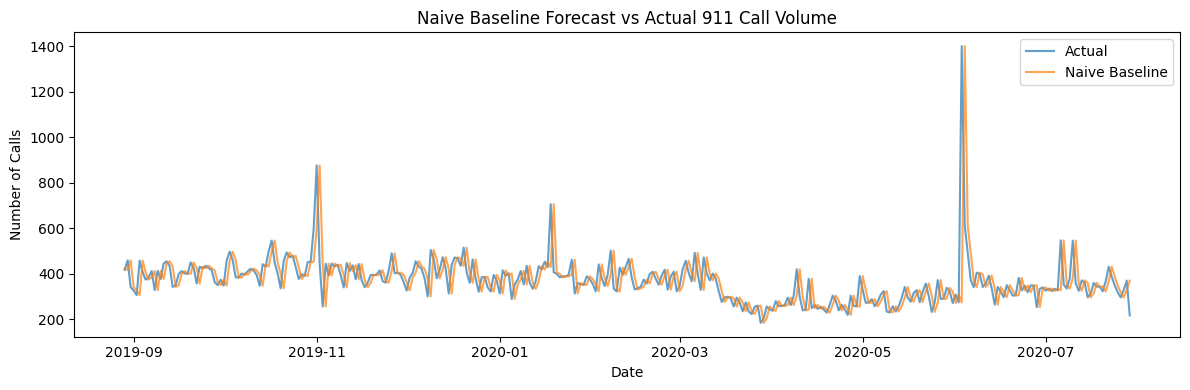

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test, label="Actual", alpha=0.7)
plt.plot(y_test.index, y_pred_naive, label="Naive Baseline", alpha=0.7)
plt.title("Naive Baseline Forecast vs Actual 911 Call Volume")
plt.xlabel("Date")
plt.ylabel("Number of Calls")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Training and test series for SARIMA
y_train_ts = y_train
y_test_ts = y_test

y_train_ts.head()

timeStamp
2015-12-24    447
2015-12-25    321
2015-12-26    286
2015-12-27    317
2015-12-28    380
Freq: D, Name: call_volume, dtype: int64

In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(
    y_train_ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit(disp=False)

sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       call_volume   No. Observations:                 1344
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7732.828
Date:                           Tue, 20 Jan 2026   AIC                          15475.657
Time:                                   02:05:20   BIC                          15501.610
Sample:                               12-24-2015   HQIC                         15485.385
                                    - 08-28-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2438      0.020     12.225      0.000       0.205       0.283
ma.L1         -0.9930      0.005   -193.843      0.000      -1.003      -0.983
ar.S.L7        0.0019      0.032      0.061      0.952      -0.060       0.064
ma.S.L7       -1.0000      0.005   -217.275      0.000      -1.009      -0.991
sigma2      6548.6843   7.03e-07   9.31e+09      0.000    6548.684    6548.684
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2419499.20
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.08   Skew:                            10.92
Prob(H) (two-sided):                  0.00   Kurtosis:                       211.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.44e+25. Standard errors may be unstable.
"""

In [20]:
# Forecast for the test period
n_test = len(y_test_ts)

sarima_forecast = sarima_result.forecast(steps=n_test)

# Align forecast index with test dates
sarima_forecast.index = y_test_ts.index

sarima_forecast.head()

timeStamp
2019-08-29    426.956374
2019-08-30    445.821552
2019-08-31    389.013988
2019-09-01    344.977548
2019-09-02    420.381490
Freq: D, Name: predicted_mean, dtype: float64

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Evaluate SARIMA forecast
mae_sarima = mean_absolute_error(y_test_ts, sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(y_test_ts, sarima_forecast))

mae_sarima, rmse_sarima

(72.57415813297737, np.float64(105.7164071783294))

In [22]:
# Alternative SARIMA with less differencing
sarima_model_v2 = SARIMAX(
    y_train_ts,
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result_v2 = sarima_model_v2.fit(disp=False)
sarima_result_v2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       call_volume   No. Observations:                 1344
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -7735.299
Date:                           Tue, 20 Jan 2026   AIC                          15480.598
Time:                                   02:05:37   BIC                          15506.555
Sample:                               12-24-2015   HQIC                         15490.327
                                    - 08-28-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3509      0.098      3.582      0.000       0.159       0.543
ma.L1         -0.1041      0.102     -1.026      0.305      -0.303       0.095
ar.S.L7       -0.0006      0.036     -0.016      0.987      -0.070       0.069
ma.S.L7       -0.9830      0.011    -90.274      0.000      -1.004      -0.962
sigma2      6616.4654     34.613    191.155      0.000    6548.625    6684.306
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2468308.87
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            11.08
Prob(H) (two-sided):                  0.00   Kurtosis:                       213.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
# Forecast using SARIMA v2
sarima_forecast_v2 = sarima_result_v2.forecast(steps=len(y_test_ts))
sarima_forecast_v2.index = y_test_ts.index

sarima_forecast_v2.head()

timeStamp
2019-08-29    426.809568
2019-08-30    438.077089
2019-08-31    380.144928
2019-09-01    335.957283
2019-09-02    416.482913
Freq: D, Name: predicted_mean, dtype: float64

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_sarima_v2 = mean_absolute_error(y_test_ts, sarima_forecast_v2)
rmse_sarima_v2 = np.sqrt(mean_squared_error(y_test_ts, sarima_forecast_v2))

mae_sarima_v2, rmse_sarima_v2

(66.42086607528152, np.float64(100.61808503926679))

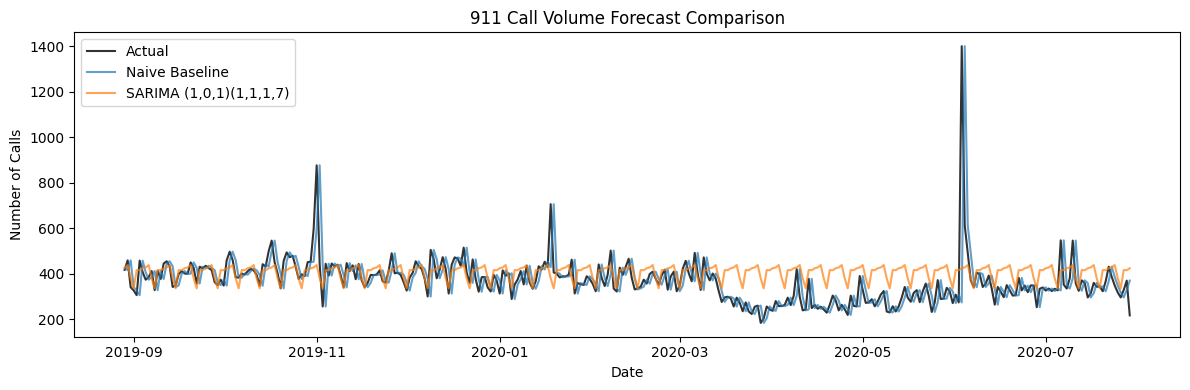

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Actual values
plt.plot(y_test_ts.index, y_test_ts, label="Actual", color="black", alpha=0.8)

# Naive baseline
plt.plot(y_test_ts.index, y_pred_naive, label="Naive Baseline", alpha=0.7)

# SARIMA v2
plt.plot(y_test_ts.index, sarima_forecast_v2, label="SARIMA (1,0,1)(1,1,1,7)", alpha=0.7)

plt.title("911 Call Volume Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Number of Calls")
plt.legend()
plt.tight_layout()
plt.show()

## Business Insights & Operational Implications


### 1. Weekly Demand Patterns

Analysis shows that 911 call volume is consistently higher on weekdays, peaking on Fridays, with a noticeable drop on weekends—especially Sundays.

**Operational implication:**  
Emergency services can plan for higher baseline staffing during weekdays, while maintaining flexible surge capacity for weekends when demand is lower but more unpredictable.

### 2. Seasonal Demand Patterns

Monthly analysis reveals moderate seasonality in emergency call volume, with higher demand during late fall and early winter months, and relatively lower demand in spring.

**Operational implication:**  
Emergency response agencies can use seasonal forecasts to anticipate periods of elevated demand and plan staffing, training, and equipment readiness ahead of time, rather than reacting to spikes after they occur.

### 3. Risk of Under-Forecasting Emergency Demand

Forecast evaluation shows that while a naive baseline performs well on average, it is prone to large errors during sudden demand spikes. These under-forecasting events pose significant operational risks in emergency response settings.

**Operational implication:**  
In public safety contexts, reducing large forecast errors is often more critical than minimizing average error. Models that better control extreme deviations can help prevent understaffing during high-impact events such as severe weather, holidays, or large public gatherings.

### 4. How Emergency Services Would Use This Forecast

The daily call volume forecast can be used as a planning input rather than an exact prediction. Emergency response agencies could use the forecast to establish baseline staffing levels, identify high-risk days, and trigger contingency plans when projected demand exceeds normal thresholds.

**Operational implication:**  
Rather than replacing human judgment, the forecast supports proactive decision-making by highlighting periods of elevated risk. This enables agencies to pre-position resources, adjust shift schedules, and coordinate across police, fire, and medical services to maintain response time targets.